# Exploratory Data Analysis (EDA)

## Table of contents
* [1. Import libraries](#1.-Import-libraries)
* [2. Dataset Overview](#2.-Dataset-Overview)
* [3. EDA](#3.-EDA)
    * [3.1 Deal with Traing Data](#3.1-Deal-with-Traing-Data)
    * [3.2 Deal with Attributes](#3.2-Deal-with-Attributes)
    * [3.3 Deal with Product Descriptions](#3.3-Deal-with-Product-Descriptions)
* [4. EDA Final Report](#4.-EDA-Final-Report)
    

## 1. Import libraries

In [1]:
# basic libraries
import pandas as pd
import numpy as np

# help data frame can show side by side 
from IPython.display import display,HTML

# statistic libraries
import seaborn as sns
from scipy.stats import norm
from scipy import stats
# plot
import matplotlib.pyplot as plt


# release memory 
import gc 

# loop step
from tqdm import tqdm

# print color text
from termcolor import colored

In [2]:
df_train = pd.read_csv('../Data/train.csv', encoding="ISO-8859-1")
df_test = pd.read_csv('../Data/test.csv', encoding="ISO-8859-1")
df_attributes = pd.read_csv('../Data/attributes.csv')
df_product_descriptions = pd.read_csv('../Data/product_descriptions.csv')

## 2. Dataset Overview

In [3]:
# let data frame display flexible, show whole value in cell
def grid_df_display(list_df, list_df_name, list_number_of_data, row = 1, col=1, fill = 'cols'):
    html_table = "<table style='width:100%; border:0px'>{content}</table>"
    html_row = "<tr style='border:0px'>{content}</tr>"
    html_cell = "<td style='width:{width}%;vertical-align:top;border:0px'>{{content}}</td>"
    html_cell = html_cell.format(width=100/col)
    
    li = []
    for i in range(len(list_df)):
        li.append(list_df[i].head(list_number_of_data[i]).
                  style.set_table_attributes("style='display:inline'").
                  set_caption(f'<b><H2>{list_df_name[i]}<H2></b>')
                 )
    
    
    cell = [ html_cell.format(content=df.render()) for df in li[:row*col] ]
    cell += col * [html_cell.format(content="")] # pad

    if fill == 'row': #fill in rows first (first row: 0,1,2,... col-1)
        grid = [ html_row.format(content="".join(cell[i:i+col])) for i in range(0,row*col,col)]

    if fill == 'col': #fill columns first (first column: 0,1,2,..., rows-1)
        grid = [ html_row.format(content="".join(cell[i:row*col:row])) for i in range(0,row)]
    
    display(HTML(html_table.format(content="".join(grid))))

In [4]:
grid_df_display(list_df = [df_train, df_attributes, df_test, df_product_descriptions], 
                list_df_name = ['Traing Data', 'Attributes', 'Test Data', 'Product Descriptions'],
                list_number_of_data = [5, 28, 6, 5], row = 2, col = 2, fill = 'col')

In [5]:
print(f'df_test shape: {df_test.shape}')
print(f'df_attributes shape: {df_attributes.shape}')
print(f'df_product_descriptions shape: {df_product_descriptions.shape}')

df_test shape: (166693, 4)
df_attributes shape: (2044803, 3)
df_product_descriptions shape: (124428, 2)


## 3. EDA

**Descriptive Analysis of the Training Dataset.**


### 3.1 Deal with Traing Data

In [6]:
# let cell can show whole value
df_train.head().style.set_table_attributes("style='display:inline'").set_caption(f'<b><H2>Traing Data<H2></b>')

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.000000
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.500000
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 Tugboat Wood and Concrete Coating,deck over,3.000000
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Kit in Chrome (Valve Not Included),rain shower head,2.330000
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Kit in Chrome (Valve Not Included),shower only faucet,2.670000


In [7]:
print(f'df_train shape: {df_train.shape}')

df_train shape: (74067, 5)


In [8]:
# check duplicates
if len(df_train.drop_duplicates(['id', 'product_uid', 'product_title', 'search_term', 'relevance']))==df_train.shape[0]:
    print('df_train: 資料未有重復項')
else:
    print('df_train: 資料有重復項')

df_train: 資料未有重復項


In [9]:
df_column_type = pd.DataFrame(df_train.dtypes, columns = ['column_type'])
df_Non_Null_Count = pd.DataFrame(df_train.notnull().sum(), columns = ['Non_Null_Count'])
df_info = pd.concat([df_column_type, df_Non_Null_Count ], axis = 1)

display(df_info)
print('-------------------------------------------------------------')
print(f'total columns: {df_train.shape[1]}')
print('-------------------------------------------------------------')
temp = pd.DataFrame(df_train.dtypes, columns = ['dtypes']).groupby('dtypes').size()
temp = pd.DataFrame(temp, columns = ['count'])
temp = temp.reset_index(drop = False)
temp = temp.astype({"dtypes": str})
column_type_count = [(temp['dtypes'][i],temp['count'][i]) for i in range(len(temp))]
print('column type count:')
print(column_type_count)

temp = pd.DataFrame(df_train.memory_usage(), columns = ['memory_usage'])
temp = temp.reset_index(drop = False)
temp.columns = ['item','memory_usage']
column_memory_usage = [(temp['item'][i],temp['memory_usage'][i]) for i in range(len(temp))]
print('-------------------------------------------------------------')
print('column memory usage (bytes):')
print(column_memory_usage)

,column_type,Non_Null_Count
id,int64,74067
product_uid,int64,74067
product_title,object,74067
search_term,object,74067
relevance,float64,74067


-------------------------------------------------------------
total columns: 5
-------------------------------------------------------------
column type count:
[('int64', 2), ('float64', 1), ('object', 2)]
-------------------------------------------------------------
column memory usage (bytes):
[('Index', 128), ('id', 592536), ('product_uid', 592536), ('product_title', 592536), ('search_term', 592536), ('relevance', 592536)]


* ### Convert id and product_uid's type to 'object'

In [10]:
df_train[['id', 'product_uid']] = df_train[['id', 'product_uid']].astype('object')

* ### Object & Numerical Data Summary

The top is the most common value. The freq is the most common value’s frequency.

In [11]:
grid_df_display(list_df = [df_train.describe(include="O"), df_train.describe()], 
                list_df_name = ['Descriptive Analysis (object)', 'Descriptive Analysis (numerical)'],
                list_number_of_data = [len(df_train.describe(include="O")), len(df_train.describe())], row = 1, col = 3, fill = 'col')

* ###  Check  distribution for target variable

In [12]:
# the target variable is discrete
df_train['relevance'].unique()

array([3.  , 2.5 , 2.33, 2.67, 2.  , 1.  , 1.67, 1.33, 1.25, 2.75, 1.75,
       1.5 , 2.25])

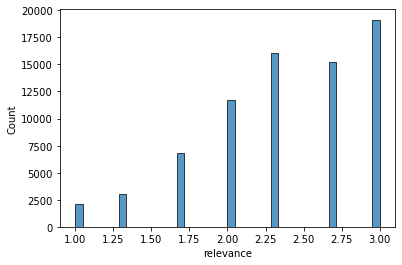

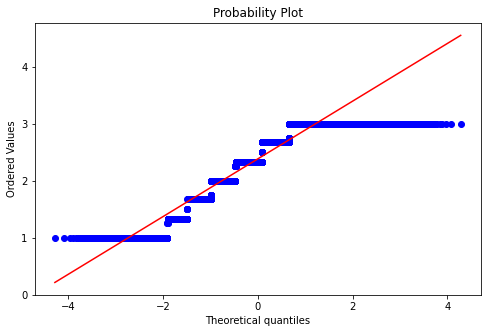

In [13]:
#histogram and normal probability plot
sns.histplot(df_train['relevance']);
fig = plt.figure(num=3, figsize=(8, 5))
res = stats.probplot(df_train['relevance'], plot=plt)

* ###  EDA with `search_term` column

<div class="alert alert-warning" role="alert">
  <strong>Note!</strong> I want to familiar with customer <strong>search term</strong>, but time is money. So I <strong>only</strong> check the <strong>search term</strong> that was searched many times. 
</div>

In [14]:
search_term_count = df_train.groupby(['search_term']).count()
search_term_count = search_term_count.reset_index(drop=False)
search_term_count = search_term_count[['search_term', 'id']]
search_term_count.columns = ['search_term', 'ncount']

In [15]:
search_term_count = search_term_count.sort_values(by='ncount', ascending=False )
search_term_count = search_term_count.reset_index(drop=True)

In [16]:
search_term_count.head(35)

,search_term,ncount
0,burgundy red foot stools,16
1,metal sheet,16
2,1/2 zip wall,16
3,bed frames headboaed,16
4,anderson windows 400 seriesimpact resistant,16
5,everblit heavy duty canvas dropcloth,16
6,moen chat oil bronze tub/shower faucet,16
7,contact paoer,16
8,3 WAY TOGGLE SWITCH,16
9,wrt111sfdb ice maker,15


## 3.2 Deal with Attributes

In [17]:
# let cell can show whole value
df_attributes.head().style.set_table_attributes("style='display:inline'").set_caption(f'<b><H2>Attributes<H2></b>')

,product_uid,name,value
0,100001.000000,Bullet01,Versatile connector for various 90° connections and home repair projects
1,100001.000000,Bullet02,Stronger than angled nailing or screw fastening alone
2,100001.000000,Bullet03,Help ensure joints are consistently straight and strong
3,100001.000000,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.000000,Bullet05,Made from 12-Gauge steel


In [18]:
print(f'df_attributes shape: {df_attributes.shape}')

df_attributes shape: (2044803, 3)


* ### Check Data Whether Duplicates

In [19]:
# check duplicates
if len(df_attributes.drop_duplicates(['product_uid', 'name', 'value']))==df_attributes.shape[0]:
    print('df_attributes: 資料未有重復項')
else:
    print('df_attributes: 資料有重復項')

df_attributes: 資料有重復項


In [20]:
# first : All duplicates except their first occurrence will be marked as True
# last : All duplicates except their last occurrence will be marked as True
# False : All duplicates except will be marked as True
df_attributes[df_attributes.duplicated(subset=['product_uid', 'name', 'value'], keep= 'first')]

,product_uid,name,value
4094,NaN,NaN,NaN
4100,NaN,NaN,NaN
6823,NaN,NaN,NaN
37309,NaN,NaN,NaN
37316,NaN,NaN,NaN
...,...,...,...
1916113,NaN,NaN,NaN
1971357,NaN,NaN,NaN
1988903,NaN,NaN,NaN
2002980,NaN,NaN,NaN


<code style="background:yellow;color:black">***It look like data frame has some duplicates. The reason is data frame get all NaN values by row.***</code>

In [21]:
# 'all' : If all values are NA, drop that row or column. 
# 'inplace': 是否在原 df 上進行操作，If True, alter datafram but return none. If false, return datafram which already drop NA row
df_attributes.dropna(how='all', inplace=True) 

In [22]:
df_column_type = pd.DataFrame(df_attributes.dtypes, columns = ['column_type'])
df_Non_Null_Count = pd.DataFrame(df_attributes.notnull().sum(), columns = ['Not_Null_Count'])
df_info = pd.concat([df_column_type, df_Non_Null_Count ], axis = 1)
display(df_info)

print('-------------------------------------------------------------')
print(f'total columns: {df_attributes.shape[1]}')
print('-------------------------------------------------------------')
temp = pd.DataFrame(df_attributes.dtypes, columns = ['dtypes']).groupby('dtypes').size()
temp = pd.DataFrame(temp, columns = ['count'])
temp = temp.reset_index(drop = False)
temp = temp.astype({"dtypes": str})
column_type_count = [(temp['dtypes'][i],temp['count'][i]) for i in range(len(temp))]
print('column type count:')
print(column_type_count)

temp = pd.DataFrame(df_attributes.memory_usage(), columns = ['memory_usage'])
temp = temp.reset_index(drop = False)
temp.columns = ['item','memory_usage']
column_memory_usage = [(temp['item'][i],temp['memory_usage'][i]) for i in range(len(temp))]
print('-------------------------------------------------------------')
print('column memory usage (bytes):')
print(column_memory_usage)

,column_type,Not_Null_Count
product_uid,float64,2044648
name,object,2044648
value,object,2042519


-------------------------------------------------------------
total columns: 3
-------------------------------------------------------------
column type count:
[('float64', 1), ('object', 2)]
-------------------------------------------------------------
column memory usage (bytes):
[('Index', 16357184), ('product_uid', 16357184), ('name', 16357184), ('value', 16357184)]


* ### Deal with NaN Data

In [23]:
df_attributes[df_attributes.notnull().value==False]

,product_uid,name,value
1022,100044.0,Collection Name,NaN
1349,100058.0,Battery Size,NaN
5909,100248.0,Fastener Thread Type,NaN
6367,100266.0,Drive Style,NaN
7898,100329.0,Fastener recommendation,NaN
...,...,...,...
2040533,224234.0,Hardware Finish Family,NaN
2040775,224246.0,Mosaic Sub Unit Length (in.),NaN
2040776,224246.0,Mosaic Sub Unit Width (in.),NaN
2041817,224289.0,Bore offset,NaN


<code style="background:yellow;color:black">***I find out df_attributes' value column has NaN. But I think NaN represent products don't have sufficient information to customers. And it usually means the product is not popular. So I convert column type to str.***</code>

In [24]:
df_attributes['value'] = df_attributes['value'].astype(str)

* ### Convert product_uid's type to 'object'

In [25]:
df_attributes[['product_uid']] = df_attributes[['product_uid']].astype('int').astype('object')

* ### Data Summary

In [26]:
grid_df_display(list_df = [df_attributes.describe(include="O")], 
                list_df_name = ['Descriptive Analysis (object)'],
                list_number_of_data = [len(df_attributes.describe(include="O"))], row = 1, col = 3, fill = 'col')

The top is the most common value. The freq is the most common value’s frequency.

<code style="background:yellow;color:black">***MFG Brand Name has the most frequency. It can be extract to be a importance feature.***</code>

* ### Find out attributes(column name) which has a lot of frequency from df_attributes.

In [27]:
df_attributes_name_count = pd.DataFrame(df_attributes.groupby(['name']).size(), columns=['frequency'])
df_attributes_name_count = df_attributes_name_count.sort_values(by= 'frequency', ascending=False).reset_index(drop = False)

In [28]:
df_attributes_name_count.head(25)

,name,frequency
0,MFG Brand Name,86250
1,Bullet02,86248
2,Bullet03,86226
3,Bullet04,86174
4,Bullet01,85940
5,Product Width (in.),61137
6,Bullet05,60529
7,Product Height (in.),54698
8,Product Depth (in.),53652
9,Product Weight (lb.),45175


<code style="background:yellow;color:black">***Product attributes such as 'MFG Brand Name', 'Color Family', 'Material', 'Color/Finish', and 'Certifications and Listings' that have a large frequency. Besides, I think these attributes are meaningful by users. So, maybe they can become an important feature for model training.***</code>

In [29]:
df_attributes_with_Color = df_attributes_name_count[df_attributes_name_count['name'].str.contains('Color')]
df_attributes_with_color = df_attributes_name_count[df_attributes_name_count['name'].str.contains('color')]

In [30]:
grid_df_display(list_df = [df_attributes_with_Color.head() , df_attributes_with_color.head()], 
                list_df_name = ["Attributes with 'Color' word", "Attributes with 'color' word"],
                list_number_of_data = [len(df_attributes_with_Color), len(df_attributes_with_color)], row = 1, col = 3, fill = 'col')

<code style="background:yellow;color:black">***I pick attributes which is product color and top 5 frequency.***</code>

* ### Check number of product attributes whether has some pattern is usable for model building

In [31]:
df_number_of_attribute = pd.DataFrame(df_attributes.groupby('product_uid').size(), 
                                      columns = ['number_of_attribute']).reset_index(drop = False)
df_number_of_attribute

,product_uid,number_of_attribute
0,100001,15
1,100002,35
2,100003,32
3,100004,25
4,100005,25
...,...,...
86258,224422,31
86259,224423,26
86260,224424,18
86261,224425,23


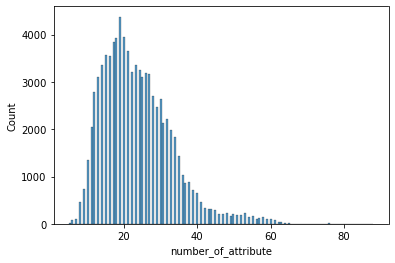

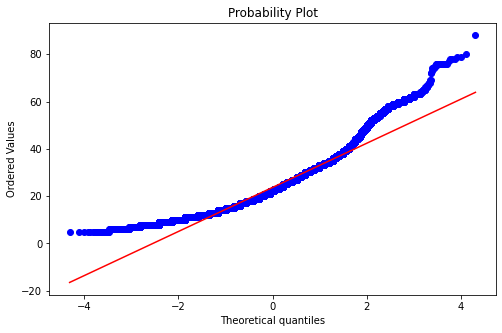

In [32]:
#histogram and normal probability plot
sns.histplot(df_number_of_attribute['number_of_attribute']);
fig = plt.figure(num=3, figsize=(8, 5))
res = stats.probplot(df_number_of_attribute['number_of_attribute'], plot=plt)

## 3.3 Deal with Product Descriptions

In [33]:
# let cell can show whole value
df_product_descriptions.head().style.set_table_attributes("style='display:inline'").set_caption(f'<b><H2>Product Descriptions<H2></b>')

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they also provide more consistent, straight corners. Simpson Strong-Tie offers a wide variety of angles in various sizes and thicknesses to handle light-duty jobs or projects where a structural connection is needed. Some can be bent (skewed) to match the project. For outdoor projects or those where moisture is present, use our ZMAX zinc-coated connectors, which provide extra resistance against corrosion (look for a ""Z"" at the end of the model number).Versatile connector for various 90 connections and home repair projectsStronger than angled nailing or screw fastening aloneHelp ensure joints are consistently straight and strongDimensions: 3 in. x 3 in. x 1-1/2 in.Made from 12-Gauge steelGalvanized for extra corrosion resistanceInstall with 10d common nails or #9 x 1-1/2 in. Strong-Drive SD screws"
1,100002,"BEHR Premium Textured DECKOVER is an innovative solid color coating. It will bring your old, weathered wood or concrete back to life. The advanced 100% acrylic resin formula creates a durable coating for your tired and worn out deck, rejuvenating to a whole new look. For the best results, be sure to properly prepare the surface using other applicable BEHR products displayed above.California residents: see Proposition 65 informationRevives wood and composite decks, railings, porches and boat docks, also great for concrete pool decks, patios and sidewalks100% acrylic solid color coatingResists cracking and peeling and conceals splinters and cracks up to 1/4 in.Provides a durable, mildew resistant finishCovers up to 75 sq. ft. in 2 coats per gallonCreates a textured, slip-resistant finishFor best results, prepare with the appropriate BEHR product for your wood or concrete surfaceActual paint colors may vary from on-screen and printer representationsColors available to be tinted in most storesOnline Price includes Paint Care fee in the following states: CA, CO, CT, ME, MN, OR, RI, VT"
2,100003,"Classic architecture meets contemporary design in the Ensemble Curve series, made of solid Vikrell material, blending sleek, clean lines with gentle curves. Corner shelving is perfect for storing bath accessories. Modular design allows it to be moved around corners and through doorways with ease. Curve wall with a smooth, contemporary look, featuring integrated storage shelves.Slightly narrower for tighter spacesDesigned with an 18 in. apronDurable high-gloss finish provides a smooth, shiny surface that is easy to cleanConforms to ANSI Z124.1.2 and CSA B45.1 national consensus standardsCurve wall with a smooth, contemporary look, featuring integrated storage shelves"
3,100004,"The Grape Solar 265-Watt Polycrystalline PV Solar Panel bonus pack bundles 4 Grape Solar 265-Watt solar panels for extra savings. The Grape Solar 265-Watt Polycrystalline PV Solar Panel uses high efficiency solar cells (approximately 19%) made from quality silicon material for high module conversion efficiency, long term output stability, and reliability. Virtually maintenance free. High transmittance, low iron tempered glass for durability and enhanced impact resistance.Positive power tolerance (0 to +5-Watt)Anti-reflective and anti-soiling surface reduces power loss from dirt and dustOutstanding performance in low-light irradiances environmentsCertified to withstand high wind and snow loads100% electroluminescence inspection ensures modules are defect freePositive and negative leads quipped with MC4 connectors"
4,100005,"Update your bathroom with the Delta Vero Single-Handle Shower Faucet Trim Kit in Chrome. It has a sleek, modern and minimalistic aesthetic. The MultiChoice universal valve keeps the water temperature within +/-3 degrees Fahrenheit to help prevent scalding.California residents: see Proposition 65 informationIncludes the trim kit only, the rough-in kit (R10000-UNBX) is sold separatelyIncludes the handleMaintains a balanced pressure of hot and cold water even when a

In [34]:
print(f'df_product_descriptions shape: {df_product_descriptions.shape}')

df_product_descriptions shape: (124428, 2)


* ### Check Data Whether Duplicates

In [35]:
# check duplicates
if len(df_product_descriptions.drop_duplicates(['product_uid', 'product_description']))==df_product_descriptions.shape[0]:
    print('df_product_descriptions: 資料未有重復項')
else:
    print('df_product_descriptions: 資料有重復項')

df_product_descriptions: 資料未有重復項


In [36]:
df_column_type = pd.DataFrame(df_product_descriptions.dtypes, columns = ['column_type'])
df_Non_Null_Count = pd.DataFrame(df_product_descriptions.notnull().sum(), columns = ['Not_Null_Count'])
df_info = pd.concat([df_column_type, df_Non_Null_Count ], axis = 1)
display(df_info)

print('-------------------------------------------------------------')
print(f'total columns: {df_product_descriptions.shape[1]}')
print('-------------------------------------------------------------')
temp = pd.DataFrame(df_product_descriptions.dtypes, columns = ['dtypes']).groupby('dtypes').size()
temp = pd.DataFrame(temp, columns = ['count'])
temp = temp.reset_index(drop = False)
temp = temp.astype({"dtypes": str})
column_type_count = [(temp['dtypes'][i],temp['count'][i]) for i in range(len(temp))]
print('column type count:')
print(column_type_count)

temp = pd.DataFrame(df_product_descriptions.memory_usage(), columns = ['memory_usage'])
temp = temp.reset_index(drop = False)
temp.columns = ['item','memory_usage']
column_memory_usage = [(temp['item'][i],temp['memory_usage'][i]) for i in range(len(temp))]
print('-------------------------------------------------------------')
print('column memory usage (bytes):')
print(column_memory_usage)

,column_type,Not_Null_Count
product_uid,int64,124428
product_description,object,124428


-------------------------------------------------------------
total columns: 2
-------------------------------------------------------------
column type count:
[('int64', 1), ('object', 1)]
-------------------------------------------------------------
column memory usage (bytes):
[('Index', 128), ('product_uid', 995424), ('product_description', 995424)]


* ### Convert product_uid's type to 'object'

In [37]:
df_product_descriptions[['product_uid']] = df_product_descriptions[['product_uid']].astype('object')

* ### Data Summary

In [38]:
grid_df_display(list_df = [df_product_descriptions.describe(include="O")], 
                list_df_name = ['Descriptive Analysis (object)'],
                list_number_of_data = [len(df_product_descriptions.describe(include="O"))], row = 1, col = 1, fill = 'col')

,product_uid,product_description
count,124428,124428
unique,124428,110128
top,224428,"Team spirit by the gallon. With the officially licensed colors from your favorite teams, you can turn any room into your dream ""Fan Cave"". Don't worry about your paint's defense either. Glidden's DUO formula is more than just a paint. It also primes with every single roll, saving you time and energy. Better yet, Glidden DUO Paint and Primer is a great value. You only have to purchase one product to get a quality primer plus a premium paint. Glidden DUO Paint and Primer is available in three sheens and 282 interior colors and is especially effective as a bathroom paint. Get going on your project today to experience beautiful, long-lasting results, guaranteed.California residents: see Proposition 65 informationExceptional hiding power for great coverage in fewer coats, even over darker colorsExcellent adhesion to most new or previously painted surfacesStain-blocking primer combined with stain-resistant paintMildew-resistant coating that's great for bathroomsEasy cleaning to keep walls looking good over timeLow odor and low VOCsActual paint colors may vary from on-screen and printer representationsOnline Price includes Paint Care fee in the following states: CA, CO, CT, MN, OR, RI, VTClick here to use our paint calculator and estimate how much paint you need to complete your project"
freq,1,43


The top is the most common value. The freq is the most common value’s frequency.<br>

<code style="background:yellow;color:black">***I find out many products got the same descriptions. I think the reason is going to happen when some similar products.***</code>

* ### Check why many products got the same descriptions

In [39]:
df_number_of_product_descriptions = pd.DataFrame(df_product_descriptions.groupby(['product_description']).size(), 
                                      columns = ['number_of_product_uid']).reset_index(drop = False)

In [40]:
df_number_of_product_descriptions

,product_description,number_of_product_uid
0,"""Building Outdoor Structures"" offers practical...",1
1,"""Code Check Commercial is a field guide for co...",1
2,"""Code Check Complete, 2nd Edition"" combines th...",1
3,"""Compost Happens the FreeGarden EARTH compost ...",1
4,"""Constructor"" Prelude door locks feature moder...",1
...,...,...
110123,the great outdoors by Minka Lavery Irvington M...,1
110124,the great outdoors by Minka Lavery Irvington M...,1
110125,the great outdoors by Minka Lavery Irvington M...,1
110126,use the 1-1/4 in. x 6 in. Polypropylene Tailpi...,1


In [41]:
df_number_of_product_descriptions_group = df_number_of_product_descriptions.sort_values(by=['number_of_product_uid'], ascending=False)

In [42]:
df_number_of_product_descriptions_group

,product_description,number_of_product_uid
51406,Team spirit by the gallon. With the officially...,43
106061,When making plans for design improvements to t...,42
25545,Glidden DUO formula is more than just a paint....,40
101706,Transform an ordinary kitchen or bathroom into...,40
39496,PVC Sch. 40 fitting that is for pressure syste...,40
...,...,...
38208,"Ordinary tap water is full of lime, calcium an...",1
38207,Ordinary golf carts and other electric vehicle...,1
38206,Order your wave moulding sample today. Welcome...,1
38205,Order your sample door and start your kitchen ...,1


In [43]:
df_number_of_product_descriptions_more_than_one = df_number_of_product_descriptions_group[df_number_of_product_descriptions_group.number_of_product_uid!=1]
df_number_of_product_descriptions_more_than_one = df_number_of_product_descriptions_more_than_one.reset_index(drop=True)

In [44]:
df_number_of_product_descriptions_more_than_one

,product_description,number_of_product_uid
0,Team spirit by the gallon. With the officially...,43
1,When making plans for design improvements to t...,42
2,Glidden DUO formula is more than just a paint....,40
3,Transform an ordinary kitchen or bathroom into...,40
4,PVC Sch. 40 fitting that is for pressure syste...,40
...,...,...
6176,"Made of heavy duty aluminum, newspaper holders...",2
6177,This distinctive door mat from Entryways' Swee...,2
6178,Economical floor padding that protects your li...,2
6179,Plugmold Tamper Resistant offers a safe and co...,2


In [45]:
unique_product_description = df_number_of_product_descriptions_more_than_one.product_description.unique()
product_id_li = []
for i in tqdm(unique_product_description):
    product_uid_with_same_product_descriptions = df_product_descriptions[df_product_descriptions.product_description==i].product_uid
    temp_li  = [i for i in product_uid_with_same_product_descriptions]
    str1 = ', '.join(str(e) for e in temp_li)
    product_id_li.append(str1)

100%|██████████| 6181/6181 [02:39<00:00, 38.74it/s]


In [46]:
df_number_of_product_descriptions_more_than_one['product_uid_with_same_product_description'] = product_id_li

In [47]:
df_number_of_product_descriptions_more_than_one

,product_description,number_of_product_uid,product_uid_with_same_product_description
0,Team spirit by the gallon. With the officially...,43,"104395, 108527, 110649, 113707, 117694, 122230..."
1,When making plans for design improvements to t...,42,"111890, 116639, 120678, 132600, 134091, 134257..."
2,Glidden DUO formula is more than just a paint....,40,"108697, 113411, 120670, 131598, 145949, 157483..."
3,Transform an ordinary kitchen or bathroom into...,40,"104333, 105535, 110627, 113089, 117217, 117684..."
4,PVC Sch. 40 fitting that is for pressure syste...,40,"105479, 105540, 109052, 109754, 109831, 110093..."
...,...,...,...
6176,"Made of heavy duty aluminum, newspaper holders...",2,"141827, 167528"
6177,This distinctive door mat from Entryways' Swee...,2,"107252, 203820"
6178,Economical floor padding that protects your li...,2,"177324, 195360"
6179,Plugmold Tamper Resistant offers a safe and co...,2,"153158, 215983"


In [48]:
df_train[df_train.product_uid==104395].product_title.values

array(['Glidden Team Colors 1-gal. #NFL-179F NFL Pittsburgh Steelers Dark Blue Flat Interior Paint and Primer'],
      dtype=object)

In [49]:
df_train[df_train.product_uid==108527].product_title.values

array(['Glidden Team Colors 1-gal. #NFL-091B NFL New York Giants Red Eggshell Interior Paint and Primer',
       'Glidden Team Colors 1-gal. #NFL-091B NFL New York Giants Red Eggshell Interior Paint and Primer'],
      dtype=object)

<code style="background:yellow;color:black">***It look like same product and brand. Only different color.***</code>

## 4. EDA Final Report 

* ```df_attributes``` has many NaN values.<br>
Condition 1: All values are NaN by row.<br>
Condition 2: Only ```column value``` is NaN.<br>
<br>
* ```MFG Brand Name``` has the most frequency in ```df_attributes```. It can be extract to be a importance feature.<br>
<br>
* Attributes of color-related which have a lot of frequency, and I think it is a great feature for model training.
<br>
<br>
* I find out many products got the same descriptions in ```df_product_descriptions```. I think the reason is going to happen when some similar products.<br>
<br>


<div class="alert alert-warning" role="alert">
  <strong>Note!</strong> If you want to convert notebook to html file, you need to save the notebook before. (CTRL+S)
</div>

In [50]:
!jupyter nbconvert EDA.ipynb --to html

[NbConvertApp] Converting notebook EDA.ipynb to html
[NbConvertApp] Writing 809221 bytes to EDA.html
